<h1> Random Proportion Modelling </h1>

In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la
from random import sample

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [2]:
# Loading in Image 

img_nifti = nib.load("cdmri11_r.nii")

img =img_nifti.dataobj[:,:,:,:]


In [3]:
img.shape

(77, 92, 56, 1344)

In [4]:
# Loading in Mask

mask_nifti = nib.load("cdmri11_mask.nii")

mask = mask_nifti.dataobj[:,:,:]

In [5]:
# Final Image 

arr = img.copy()
for i in range (0,1344):
    arr[:,:,:,i] = mask*img[:,:,:,i]; 

In [6]:
arr.shape

(77, 92, 56, 1344)

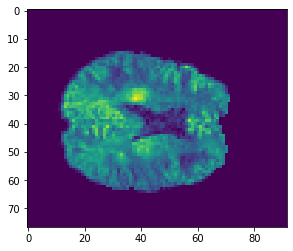

In [7]:
plt.imshow(arr[:,:,33,200])

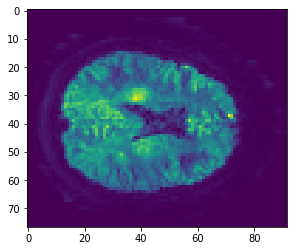

In [8]:
plt.imshow(img[:,:,33,200])

In [9]:
MD_map = np.zeros([77,92])

T1_map = np.zeros([77,92])
T2_map = np.zeros([77,92])
IE_map = np.zeros([77,92])

cost_map = np.zeros([77,92])
D_map = np.zeros([77,92,3,3])
FA_map = np.zeros([77,92])

MD_map_abs = np.zeros([77,92])

In [10]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

(1344, 6)

In [11]:
param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]

# had to check, but is correct
# np.savetxt('changed_param.txt', param, fmt='%1.5f')

param

array([[-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.0000e+01,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  1.2364e+03,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.4727e+03,
         8.0000e+01],
       ...,
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  2.2961e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  3.5325e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  7.3227e+03,
         1.3000e+02]])

In [12]:
b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]
res_selected = arr[:,:,:,indices]

In [13]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

# s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]

boundaries = [0, 1, 0, 10, 0, 0, 0, -np.inf, -np.inf, -np.inf], [np.inf, 2, 2e7, 350, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]

# Note: Thilo has no bounds on fit

<h2> Creating Model </h2>

In [14]:
# Fit Function

def Fit(x,b, TI, TR, TE, param):            

    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    return S

# Simple Exponential Cost Function

def FitCost(x, b, TI, TR, TE, param, slslice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    res = slslice[0,:] -S
    return res

In [15]:


def MD(b, TI, TR, TE, param, slslice, boundaries):

    # Perform Non-Linear Least Squares Fit

    x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]
    # for x[4], values of 0.01, 1 would lead to a straight line at 0, 
    # while 10 and 100 works fine

    lsr = least_squares(FitCost, x0, args=(b,TI, TR, TE, param, slslice), bounds=(boundaries), max_nfev=5000)
    cost = lsr.cost
    jac = lsr.jac
    values = lsr.x

    # Computing Mean Diffusivity
    # Diffusion Tensor
    D = [[values[4], values[7], values[8]], 
         [values[7], values[5], values[9]], 
         [values[8], values[9], values[6]]]

    # Eigenvectors and Eigenvalues 
    [evecs , evals] = la.eig(D)
    i = np.argsort(np.diag(evals))
    evals = np.diag(evals)[i]

    # Calculating MD 
    MD = (evals[0]+evals[1]+evals[2])/3
    return MD


def Maps(b, TI, TR, TE, param, slslice, boundaries):

    # Perform Non-Linear Least Squares Fit

    x0 = [300, 2, 1000, 100, 1, 1, 1,0,0,0]
    # for x[4], values of 0.01, 1 would lead to a straight line at 0, 
    # while 10 and 100 works fine

    lsr = least_squares(FitCost, x0, args=(b,TI, TR, TE, param, slslice), bounds=(boundaries), max_nfev=5000)
    cost = lsr.cost
    jac = lsr.jac
    values = lsr.x

    # Computing Mean Diffusivity
    # Diffusion Tensor
    D = [[values[4], values[7], values[8]], 
         [values[7], values[5], values[9]], 
         [values[8], values[9], values[6]]]

    # Eigenvectors and Eigenvalues 
    [evals , evecs] = la.eig(D)
    
    # Calculating MD 
    MD = (evals[0]+evals[1]+evals[2])/3
    FA = np.sqrt(1/2)*((np.sqrt((evals[0]-evals[1])**2+(evals[1]-evals[2])**2+(evals[2]-evals[0])**2))/np.sqrt(evals[0]**2+evals[1]**2+evals[2]**2))
    return MD, values[1],values[2],values[3], cost, FA

    # values[3]: T2* , [2]: T1, [1]: PD?, i.e. IE

<h3> Choosing Random Portion of Data </h3>

In [16]:
# Initializations
results = np.zeros((77, 92, 6, 100))
param_sel = np.zeros((100,86))
k = 86
    
# Original Parameters
param_orig = np.copy(param)
res_selected_orig = np.copy(res_selected)
b_orig = np.copy(b)
TI_orig = np.copy(TI)
TE_orig = np.copy(TE)

In [18]:
for q in range (0, 100):
    
    # Choosing random portion of Data
    ind = sample(range(param_orig.shape[0]), k= k)
    
    # Saving parameters chose
    param_sel[q,:] = ind
    np.savetxt('86_param_sel_modelling.txt', param_sel )
    
    # Changing Data
    param =param_orig[ind,:]
    res_selected = res_selected_orig[:,:,:,:,ind]
    b = b_orig[ind]
    TI = TI_orig[ind]
    TE = TE_orig[ind]

    # Igonring Imaginary part

    # Loop through Voxels
    for i in range (77):
        for j in range (92):
            print(i, "   " ,j )
            slslice = res_selected[i,j,33,:]
            # MD_map[i,j], IE_map[i,j],T1_map[i,j],T2_map[i,j], cost_map[i,j], FA_map[i,j]= Maps(b, TI, TR, TE, param, slslice, boundaries)
            results[i,j,0,q], results[i,j,1,q],results[i,j,2,q],results[i,j,3,q], results[i,j,4,q], results[i,j,5,q]= Maps(b, TI, TR, TE, param, slslice, boundaries)

    # Saving Array as Nifti
    nifti_img = nib.Nifti1Image(results, affine = None)
    nib.save(nifti_img, 'param_86_res_modelling.nii')

0     0
0     1
0     2
0     3
0     4
0     5
0     6
0     7
0     8
0     9
0     10
0     11
0     12
0     13
0     14
0     15
0     16
0     17
0     18
0     19
0     20
0     21
0     22
0     23
0     24
0     25
0     26
0     27
0     28
0     29
0     30
0     31
0     32
0     33
0     34
0     35
0     36
0     37
0     38
0     39
0     40
0     41
0     42
0     43
0     44
0     45
0     46
0     47
0     48
0     49
0     50
0     51
0     52
0     53
0     54
0     55
0     56
0     57
0     58
0     59
0     60
0     61
0     62
0     63
0     64
0     65
0     66
0     67
0     68
0     69
0     70
0     71
0     72
0     73
0     74
0     75
0     76
0     77
0     78
0     79
0     80
0     81
0     82
0     83
0     84
0     85
0     86
0     87
0     88
0     89
0     90
0     91
1     0
1     1
1     2
1     3
1     4
1     5
1     6
1     7
1     8
1     9
1     10
1     11
1     12
1     13
1     14
1     15
1     16
1     17
1     18
1     19
1     20
1  

10     4
10     5
10     6
10     7
10     8
10     9
10     10
10     11
10     12
10     13
10     14
10     15
10     16
10     17
10     18
10     19
10     20
10     21
10     22
10     23
10     24
10     25
10     26
10     27
10     28
10     29
10     30
10     31
10     32
10     33
10     34
10     35
10     36
10     37
10     38
10     39
10     40
10     41
10     42
10     43
10     44
10     45
10     46
10     47
10     48
10     49
10     50
10     51
10     52
10     53
10     54
10     55
10     56
10     57
10     58
10     59
10     60
10     61
10     62
10     63
10     64
10     65
10     66
10     67
10     68
10     69
10     70
10     71
10     72
10     73
10     74
10     75
10     76
10     77
10     78
10     79
10     80
10     81
10     82
10     83
10     84
10     85
10     86
10     87
10     88
10     89
10     90
10     91
11     0
11     1
11     2
11     3
11     4
11     5
11     6
11     7
11     8
11     9
11     10
11     11
11     12
11    

19     7
19     8
19     9
19     10
19     11
19     12
19     13
19     14
19     15
19     16
19     17
19     18
19     19
19     20
19     21
19     22
19     23
19     24
19     25
19     26
19     27
19     28
19     29
19     30
19     31
19     32
19     33
19     34
19     35
19     36
19     37
19     38
19     39
19     40
19     41
19     42
19     43
19     44
19     45
19     46
19     47
19     48
19     49
19     50
19     51
19     52
19     53
19     54
19     55
19     56
19     57
19     58
19     59
19     60
19     61
19     62
19     63
19     64
19     65
19     66
19     67
19     68
19     69
19     70
19     71
19     72
19     73
19     74
19     75
19     76
19     77
19     78
19     79
19     80
19     81
19     82
19     83
19     84
19     85
19     86
19     87
19     88
19     89
19     90
19     91
20     0
20     1
20     2
20     3
20     4
20     5
20     6
20     7
20     8
20     9
20     10
20     11
20     12
20     13
20     14
20     15
20 

28     8
28     9
28     10
28     11
28     12
28     13
28     14
28     15
28     16
28     17
28     18
28     19
28     20
28     21
28     22
28     23
28     24
28     25
28     26
28     27
28     28
28     29
28     30
28     31
28     32
28     33
28     34
28     35
28     36
28     37
28     38
28     39
28     40
28     41
28     42
28     43
28     44
28     45
28     46
28     47
28     48
28     49
28     50
28     51
28     52
28     53
28     54
28     55
28     56
28     57
28     58
28     59
28     60
28     61
28     62
28     63
28     64
28     65
28     66
28     67
28     68
28     69
28     70
28     71
28     72
28     73
28     74
28     75
28     76
28     77
28     78
28     79
28     80
28     81
28     82
28     83
28     84
28     85
28     86
28     87
28     88
28     89
28     90
28     91
29     0
29     1
29     2
29     3
29     4
29     5
29     6
29     7
29     8
29     9
29     10
29     11
29     12
29     13
29     14
29     15
29     16
29

37     9
37     10
37     11
37     12
37     13
37     14
37     15
37     16
37     17
37     18
37     19
37     20
37     21
37     22
37     23
37     24
37     25
37     26
37     27
37     28
37     29
37     30
37     31
37     32
37     33
37     34
37     35
37     36
37     37
37     38
37     39
37     40
37     41
37     42
37     43
37     44
37     45
37     46
37     47
37     48
37     49
37     50
37     51
37     52
37     53
37     54
37     55
37     56
37     57
37     58
37     59
37     60
37     61
37     62
37     63
37     64
37     65
37     66
37     67
37     68
37     69
37     70
37     71
37     72
37     73
37     74
37     75
37     76
37     77
37     78
37     79
37     80
37     81
37     82
37     83
37     84
37     85
37     86
37     87
37     88
37     89
37     90
37     91
38     0
38     1
38     2
38     3
38     4
38     5
38     6
38     7
38     8
38     9
38     10
38     11
38     12
38     13
38     14
38     15
38     16
38     17
3

46     12
46     13
46     14
46     15
46     16
46     17
46     18
46     19
46     20
46     21
46     22
46     23
46     24
46     25
46     26
46     27
46     28
46     29
46     30
46     31
46     32
46     33
46     34
46     35
46     36
46     37
46     38
46     39
46     40
46     41
46     42
46     43
46     44
46     45
46     46
46     47
46     48
46     49
46     50
46     51
46     52
46     53
46     54
46     55
46     56
46     57
46     58
46     59
46     60
46     61
46     62
46     63
46     64
46     65
46     66
46     67
46     68
46     69
46     70
46     71
46     72
46     73
46     74
46     75
46     76
46     77
46     78
46     79
46     80
46     81
46     82
46     83
46     84
46     85
46     86
46     87
46     88
46     89
46     90
46     91
47     0
47     1
47     2
47     3
47     4
47     5
47     6
47     7
47     8
47     9
47     10
47     11
47     12
47     13
47     14
47     15
47     16
47     17
47     18
47     19
47     20


55     14
55     15
55     16
55     17
55     18
55     19
55     20
55     21
55     22
55     23
55     24
55     25
55     26
55     27
55     28
55     29
55     30
55     31
55     32
55     33
55     34
55     35
55     36
55     37
55     38
55     39
55     40
55     41
55     42
55     43
55     44
55     45
55     46
55     47
55     48
55     49
55     50
55     51
55     52
55     53
55     54
55     55
55     56
55     57
55     58
55     59
55     60
55     61
55     62
55     63
55     64
55     65
55     66
55     67
55     68
55     69
55     70
55     71
55     72
55     73
55     74
55     75
55     76
55     77
55     78
55     79
55     80
55     81
55     82
55     83
55     84
55     85
55     86
55     87
55     88
55     89
55     90
55     91
56     0
56     1
56     2
56     3
56     4
56     5
56     6
56     7
56     8
56     9
56     10
56     11
56     12
56     13
56     14
56     15
56     16
56     17
56     18
56     19
56     20
56     21
56     22


64     16
64     17
64     18
64     19
64     20
64     21
64     22
64     23
64     24
64     25
64     26
64     27
64     28
64     29
64     30
64     31
64     32
64     33
64     34
64     35
64     36
64     37
64     38
64     39
64     40
64     41
64     42
64     43
64     44
64     45
64     46
64     47
64     48
64     49
64     50
64     51
64     52
64     53
64     54
64     55
64     56
64     57
64     58
64     59
64     60
64     61
64     62
64     63
64     64
64     65
64     66
64     67
64     68
64     69
64     70
64     71
64     72
64     73
64     74
64     75
64     76
64     77
64     78
64     79
64     80
64     81
64     82
64     83
64     84
64     85
64     86
64     87
64     88
64     89
64     90
64     91
65     0
65     1
65     2
65     3
65     4
65     5
65     6
65     7
65     8
65     9
65     10
65     11
65     12
65     13
65     14
65     15
65     16
65     17
65     18
65     19
65     20
65     21
65     22
65     23
65     24


73     22
73     23
73     24
73     25
73     26
73     27
73     28
73     29
73     30
73     31
73     32
73     33
73     34
73     35
73     36
73     37
73     38
73     39
73     40
73     41
73     42
73     43
73     44
73     45
73     46
73     47
73     48
73     49
73     50
73     51
73     52
73     53
73     54
73     55
73     56
73     57
73     58
73     59
73     60
73     61
73     62
73     63
73     64
73     65
73     66
73     67
73     68
73     69
73     70
73     71
73     72
73     73
73     74
73     75
73     76
73     77
73     78
73     79
73     80
73     81
73     82
73     83
73     84
73     85
73     86
73     87
73     88
73     89
73     90
73     91
74     0
74     1
74     2
74     3
74     4
74     5
74     6
74     7
74     8
74     9
74     10
74     11
74     12
74     13
74     14
74     15
74     16
74     17
74     18
74     19
74     20
74     21
74     22
74     23
74     24
74     25
74     26
74     27
74     28
74     29
74     30


5     79
5     80
5     81
5     82
5     83
5     84
5     85
5     86
5     87
5     88
5     89
5     90
5     91
6     0
6     1
6     2
6     3
6     4
6     5
6     6
6     7
6     8
6     9
6     10
6     11
6     12
6     13
6     14
6     15
6     16
6     17
6     18
6     19
6     20
6     21
6     22
6     23
6     24
6     25
6     26
6     27
6     28
6     29
6     30
6     31
6     32
6     33
6     34
6     35
6     36
6     37
6     38
6     39
6     40
6     41
6     42
6     43
6     44
6     45
6     46
6     47
6     48
6     49
6     50
6     51
6     52
6     53
6     54
6     55
6     56
6     57
6     58
6     59
6     60
6     61
6     62
6     63
6     64
6     65
6     66
6     67
6     68
6     69
6     70
6     71
6     72
6     73
6     74
6     75
6     76
6     77
6     78
6     79
6     80
6     81
6     82
6     83
6     84
6     85
6     86
6     87
6     88
6     89
6     90
6     91
7     0
7     1
7     2
7     3
7     4
7     5
7     6
7     7
7

15     27
15     28
15     29
15     30
15     31
15     32
15     33
15     34
15     35
15     36
15     37
15     38
15     39
15     40
15     41
15     42
15     43
15     44
15     45
15     46
15     47
15     48
15     49
15     50
15     51
15     52
15     53
15     54
15     55
15     56
15     57
15     58
15     59
15     60
15     61
15     62
15     63
15     64
15     65
15     66
15     67
15     68
15     69
15     70
15     71
15     72
15     73
15     74
15     75
15     76
15     77
15     78
15     79
15     80
15     81
15     82
15     83
15     84
15     85
15     86
15     87
15     88
15     89
15     90
15     91
16     0
16     1
16     2
16     3
16     4
16     5
16     6
16     7
16     8
16     9
16     10
16     11
16     12
16     13
16     14
16     15
16     16
16     17
16     18
16     19
16     20
16     21
16     22
16     23
16     24
16     25
16     26
16     27
16     28
16     29
16     30
16     31
16     32
16     33
16     34
16     35


24     34
24     35
24     36
24     37
24     38
24     39
24     40
24     41
24     42
24     43
24     44
24     45
24     46
24     47
24     48
24     49
24     50
24     51
24     52
24     53
24     54
24     55
24     56
24     57
24     58
24     59
24     60
24     61
24     62
24     63
24     64
24     65
24     66
24     67
24     68
24     69
24     70
24     71
24     72
24     73
24     74
24     75
24     76
24     77
24     78
24     79
24     80
24     81
24     82
24     83
24     84
24     85
24     86
24     87
24     88
24     89
24     90
24     91
25     0
25     1
25     2
25     3
25     4
25     5
25     6
25     7
25     8
25     9
25     10
25     11
25     12
25     13
25     14
25     15
25     16
25     17
25     18
25     19
25     20
25     21
25     22
25     23
25     24
25     25
25     26
25     27
25     28
25     29
25     30
25     31
25     32
25     33
25     34
25     35
25     36
25     37
25     38
25     39
25     40
25     41
25     42


33     37
33     38
33     39
33     40
33     41
33     42
33     43
33     44
33     45
33     46
33     47
33     48
33     49
33     50
33     51
33     52
33     53
33     54
33     55
33     56
33     57
33     58
33     59
33     60
33     61
33     62
33     63
33     64
33     65
33     66
33     67
33     68
33     69
33     70
33     71
33     72
33     73
33     74
33     75
33     76
33     77
33     78
33     79
33     80
33     81
33     82
33     83
33     84
33     85
33     86
33     87
33     88
33     89
33     90
33     91
34     0
34     1
34     2
34     3
34     4
34     5
34     6
34     7
34     8
34     9
34     10
34     11
34     12
34     13
34     14
34     15
34     16
34     17
34     18
34     19
34     20
34     21
34     22
34     23
34     24
34     25
34     26
34     27
34     28
34     29
34     30
34     31
34     32
34     33
34     34
34     35
34     36
34     37
34     38
34     39
34     40
34     41
34     42
34     43
34     44
34     45


42     38
42     39
42     40
42     41
42     42
42     43
42     44
42     45
42     46
42     47
42     48
42     49
42     50
42     51
42     52
42     53
42     54
42     55
42     56
42     57
42     58
42     59
42     60
42     61
42     62
42     63
42     64
42     65
42     66
42     67
42     68
42     69
42     70
42     71
42     72
42     73
42     74
42     75
42     76
42     77
42     78
42     79
42     80
42     81
42     82
42     83
42     84
42     85
42     86
42     87
42     88
42     89
42     90
42     91
43     0
43     1
43     2
43     3
43     4
43     5
43     6
43     7
43     8
43     9
43     10
43     11
43     12
43     13
43     14
43     15
43     16
43     17
43     18
43     19
43     20
43     21
43     22
43     23
43     24
43     25
43     26
43     27
43     28
43     29
43     30
43     31
43     32
43     33
43     34
43     35
43     36
43     37
43     38
43     39
43     40
43     41
43     42
43     43
43     44
43     45
43     46


51     39
51     40
51     41
51     42
51     43
51     44
51     45
51     46
51     47
51     48
51     49
51     50
51     51
51     52
51     53
51     54
51     55
51     56
51     57
51     58
51     59
51     60
51     61
51     62
51     63
51     64
51     65
51     66
51     67
51     68
51     69
51     70
51     71
51     72
51     73
51     74
51     75
51     76
51     77
51     78
51     79
51     80
51     81
51     82
51     83
51     84
51     85
51     86
51     87
51     88
51     89
51     90
51     91
52     0
52     1
52     2
52     3
52     4
52     5
52     6
52     7
52     8
52     9
52     10
52     11
52     12
52     13
52     14
52     15
52     16
52     17
52     18
52     19
52     20
52     21
52     22
52     23
52     24
52     25
52     26
52     27
52     28
52     29
52     30
52     31
52     32
52     33
52     34
52     35
52     36
52     37
52     38
52     39
52     40
52     41
52     42
52     43
52     44
52     45
52     46
52     47


60     43
60     44
60     45
60     46
60     47
60     48
60     49
60     50
60     51
60     52
60     53
60     54
60     55
60     56
60     57
60     58
60     59
60     60
60     61
60     62
60     63
60     64
60     65
60     66
60     67
60     68
60     69
60     70
60     71
60     72
60     73
60     74
60     75
60     76
60     77
60     78
60     79
60     80
60     81
60     82
60     83
60     84
60     85
60     86
60     87
60     88
60     89
60     90
60     91
61     0
61     1
61     2
61     3
61     4
61     5
61     6
61     7
61     8
61     9
61     10
61     11
61     12
61     13
61     14
61     15
61     16
61     17
61     18
61     19
61     20
61     21
61     22
61     23
61     24
61     25
61     26
61     27
61     28
61     29
61     30
61     31
61     32
61     33
61     34
61     35
61     36
61     37
61     38
61     39
61     40
61     41
61     42
61     43
61     44
61     45
61     46
61     47
61     48
61     49
61     50
61     51


69     44
69     45
69     46
69     47
69     48
69     49
69     50
69     51
69     52
69     53
69     54
69     55
69     56
69     57
69     58
69     59
69     60
69     61
69     62
69     63
69     64
69     65
69     66
69     67
69     68
69     69
69     70
69     71
69     72
69     73
69     74
69     75
69     76
69     77
69     78
69     79
69     80
69     81
69     82
69     83
69     84
69     85
69     86
69     87
69     88
69     89
69     90
69     91
70     0
70     1
70     2
70     3
70     4
70     5
70     6
70     7
70     8
70     9
70     10
70     11
70     12
70     13
70     14
70     15
70     16
70     17
70     18
70     19
70     20
70     21
70     22
70     23
70     24
70     25
70     26
70     27
70     28
70     29
70     30
70     31
70     32
70     33
70     34
70     35
70     36
70     37
70     38
70     39
70     40
70     41
70     42
70     43
70     44
70     45
70     46
70     47
70     48
70     49
70     50
70     51
70     52
